In [195]:

# 1️⃣ Import Libraries
# ============================================================


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid", palette="viridis")


In [196]:

# ============================================================
# 📂 Load Dataset
# ============================================================

df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")
print("✅ Dataset loaded successfully! Shape:", df.shape)

✅ Dataset loaded successfully! Shape: (374, 13)


In [197]:
# Clean column names
df.columns = df.columns.str.strip().str.replace(" ", "_")
print(df.columns)
print("✅ Column names cleaned!")

Index(['Person_ID', 'Gender', 'Age', 'Occupation', 'Sleep_Duration',
       'Quality_of_Sleep', 'Physical_Activity_Level', 'Stress_Level',
       'BMI_Category', 'Blood_Pressure', 'Heart_Rate', 'Daily_Steps',
       'Sleep_Disorder'],
      dtype='object')
✅ Column names cleaned!


In [198]:

# Quick preview
df.head()

,Person_ID,Gender,Age,Occupation,Sleep_Duration,Quality_of_Sleep,Physical_Activity_Level,Stress_Level,BMI_Category,Blood_Pressure,Heart_Rate,Daily_Steps,Sleep_Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [199]:
# ============================================================
# 🧼 Data Cleaning
# ============================================================

df.drop_duplicates(inplace=True)
df.dropna(how='all', inplace=True)

# Split Blood Pressure (e.g., "120/80")
if 'Blood_Pressure' in df.columns:
    bp_split = df['Blood_Pressure'].astype(str).str.split('/', expand=True)
    df['Systolic_BP'] = pd.to_numeric(bp_split[0], errors='coerce')
    df['Diastolic_BP'] = pd.to_numeric(bp_split[1], errors='coerce')
    df.drop(columns=['Blood_Pressure'], inplace=True)

# Fill null values
for col in df.columns:
    if df[col].dtype in [int, float]:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("✅ Data cleaned. Current shape:", df.shape)
df.head()


✅ Data cleaned. Current shape: (374, 14)


,Person_ID,Gender,Age,Occupation,Sleep_Duration,Quality_of_Sleep,Physical_Activity_Level,Stress_Level,BMI_Category,Heart_Rate,Daily_Steps,Sleep_Disorder,Systolic_BP,Diastolic_BP
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,Sleep Apnea,126,83
1,2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,Sleep Apnea,125,80
2,3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,Sleep Apnea,125,80
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


In [200]:
# ============================================================
# 🎛️ Add Controlled Random Noise to Avoid Overfitting
# ============================================================

numeric_cols = ['Sleep_Duration', 'Stress_Level', 'Physical_Activity_Level', 'Heart_Rate', 'Daily_Steps']

for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col] + np.random.normal(0, 0.3, len(df))
        df[col] = df[col].clip(lower=0)

print("✅ Controlled noise added successfully.")


✅ Controlled noise added successfully.


In [201]:

# ============================================================
# 💤 Create Sleep Quality Labels
# ============================================================

df['Quality_of_Sleep'] = pd.to_numeric(df['Quality_of_Sleep'], errors='coerce')

def label_sleep_quality(x):
    if x >= 7:
        return "Good"
    elif x >= 5:
        return "Average"
    else:
        return "Poor"

df['SleepQualityLabel'] = df['Quality_of_Sleep'].apply(label_sleep_quality)
print("\n✅ Label Distribution:")
print(df['SleepQualityLabel'].value_counts())

df[['Quality_of_Sleep', 'SleepQualityLabel']].head(10)



✅ Label Distribution:
SleepQualityLabel
Good       257
Average    112
Poor         5
Name: count, dtype: int64


,Quality_of_Sleep,SleepQualityLabel
0,6,Average
1,6,Average
2,6,Average
3,4,Poor
4,4,Poor
5,4,Poor
6,6,Average
7,7,Good
8,7,Good
9,7,Good


In [202]:
# ============================================================
# 🧠 Feature Engineering
# ============================================================

# Lifestyle indicators
df['ActiveLifestyle'] = np.where(df['Physical_Activity_Level'] > 45, 1, 0)
df['HighStress'] = np.where(df['Stress_Level'] >= 7, 1, 0)

# Add behavioral variables
df['Caffeine_Intake'] = np.round(
    np.random.normal(loc=150 + df['Stress_Level'] * 10, scale=30, size=len(df))
)
df['Caffeine_Intake'] = df['Caffeine_Intake'].clip(lower=0, upper=400)

df['ScreenTime'] = np.round(
    np.random.normal(
        loc=4 + (df['Stress_Level'] / 2) - (df['Physical_Activity_Level'] / 100),
        scale=0.5,
        size=len(df)
    ),
    2
)
df['ScreenTime'] = df['ScreenTime'].clip(lower=1, upper=10)

print("✅ Added new features: Caffeine_Intake, ScreenTime")
df[['Stress_Level', 'Caffeine_Intake', 'ScreenTime']].head(10)


✅ Added new features: Caffeine_Intake, ScreenTime


,Stress_Level,Caffeine_Intake,ScreenTime
0,6.195790,213.0,7.64
1,7.707093,256.0,6.86
2,8.109845,225.0,7.37
3,8.006001,236.0,7.75
4,7.927162,229.0,8.15
5,7.983431,229.0,7.54
6,7.336510,210.0,7.60
7,6.130581,243.0,6.88
8,5.667409,215.0,6.43
9,6.268204,204.0,6.29


In [203]:
# ============================================================
# 🔤 Encode Categorical Data
# ============================================================

le = LabelEncoder()
for col in ['Gender', 'Occupation', 'BMI_Category', 'Sleep_Disorder']:
    df[col] = le.fit_transform(df[col].astype(str))

label_map = {'Good': 0, 'Average': 1, 'Poor': 2}
df['SleepQualityLabel'] = df['SleepQualityLabel'].map(label_map)

print("✅ Encoding done.")
df.head()


✅ Encoding done.


,Person_ID,Gender,Age,Occupation,Sleep_Duration,Quality_of_Sleep,Physical_Activity_Level,Stress_Level,BMI_Category,Heart_Rate,Daily_Steps,Sleep_Disorder,Systolic_BP,Diastolic_BP,SleepQualityLabel,ActiveLifestyle,HighStress,Caffeine_Intake,ScreenTime
0,1,1,27,9,6.292966,6,41.915163,6.195790,3,77.576383,4200.410621,1,126,83,1,0,0,213.0,7.64
1,2,1,28,1,6.296100,6,60.148164,7.707093,0,75.194826,9999.809714,1,125,80,1,1,1,256.0,6.86
2,3,1,28,1,6.214044,6,60.187928,8.109845,0,75.161724,9999.754332,1,125,80,1,1,1,225.0,7.37
3,4,1,28,6,5.860902,4,29.659674,8.006001,2,85.121500,3000.267953,1,140,90,2,0,1,236.0,7.75
4,5,1,28,6,5.629604,4,29.751613,7.927162,2,85.524307,3000.155935,1,140,90,2,0,1,229.0,8.15


In [204]:
# ============================================================
# 🚫 Drop Unnecessary / Leaky Columns
# ============================================================

drop_cols = ['Person_ID', 'Sleep_Duration', 'Stress_Level', 'ActiveLifestyle', 'HighStress']
df = df.drop(columns=drop_cols, errors='ignore')

print("✅ Dropped unnecessary columns.")
print("Final Columns:", df.columns.tolist())


✅ Dropped unnecessary columns.
Final Columns: ['Gender', 'Age', 'Occupation', 'Quality_of_Sleep', 'Physical_Activity_Level', 'BMI_Category', 'Heart_Rate', 'Daily_Steps', 'Sleep_Disorder', 'Systolic_BP', 'Diastolic_BP', 'SleepQualityLabel', 'Caffeine_Intake', 'ScreenTime']


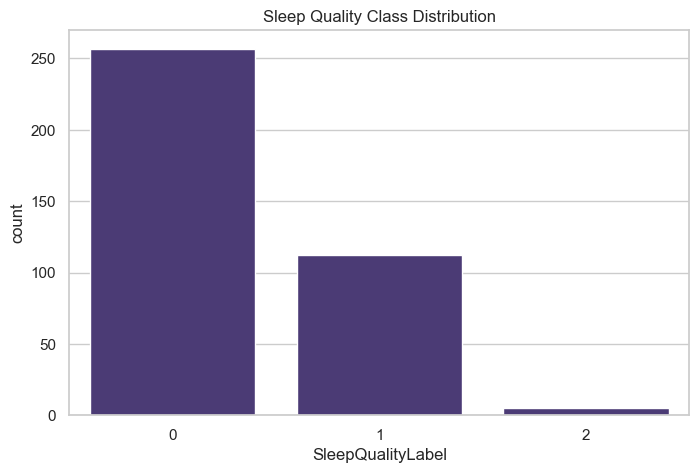

In [205]:
# ============================================================
# 📊 Exploratory Data Analysis (EDA)
# ============================================================

plt.figure(figsize=(8,5))
sns.countplot(x='SleepQualityLabel', data=df)
plt.title("Sleep Quality Class Distribution")
plt.savefig("sleep_quality_distribution.png")
plt.show()




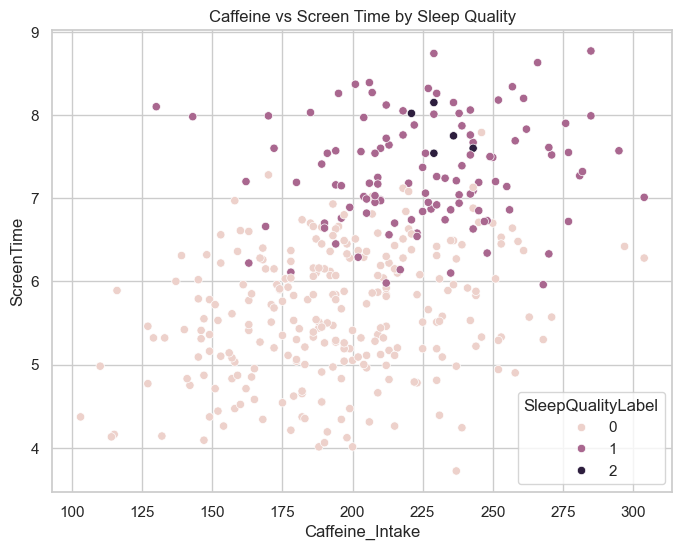

In [206]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Caffeine_Intake', y='ScreenTime', hue='SleepQualityLabel', data=df)
plt.title("Caffeine vs Screen Time by Sleep Quality")
plt.savefig("caffeine_screen_time.png")
plt.show()



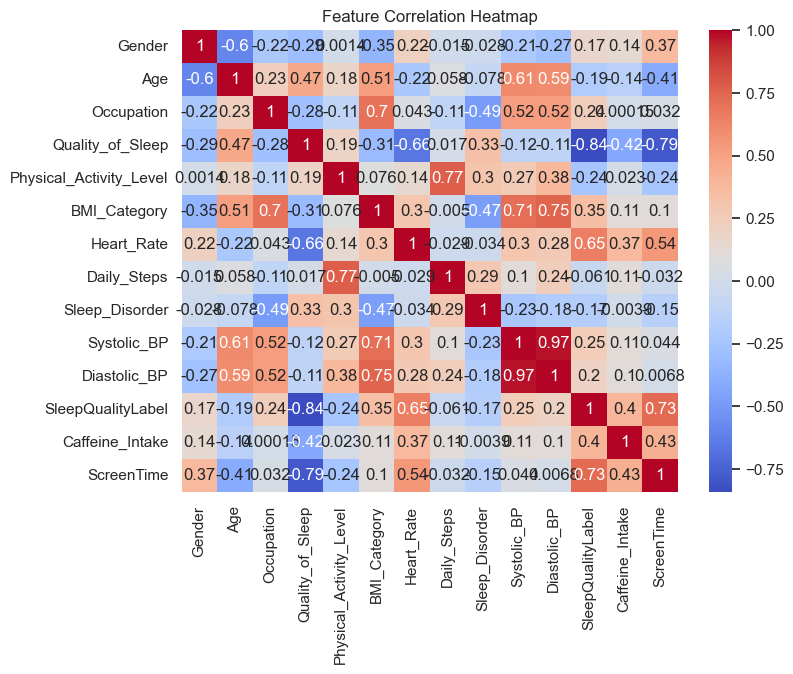

In [207]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.savefig("feature_correlation_heatmap.png")
plt.show()

In [208]:
# ============================================================
# 🧩 Train-Test Split


# Drop the numeric 'Quality_of_Sleep' — it directly defines the label
if 'Quality_of_Sleep' in df.columns:
    df = df.drop(columns=['Quality_of_Sleep'])

# Prepare feature set and target
X = df.drop(['SleepQualityLabel'], axis=1)
y = df['SleepQualityLabel']

print("✅ Data leakage fixed — target definition column removed.")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Train shape: {X_train.shape} | Test shape: {X_test.shape}")


✅ Data leakage fixed — target definition column removed.
✅ Train shape: (299, 12) | Test shape: (75, 12)


In [209]:
# ============================================================
# 🤖 Train Logistic Regression & Random Forest
# ============================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=500, random_state=42, class_weight='balanced')
rf = rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5,        # restrict complexity
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
)


lr.fit(X_train_scaled, y_train)
rf.fit(X_train, y_train)

print("✅ Models trained successfully.")


✅ Models trained successfully.



📊 Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       0.88      0.95      0.91        22
           2       0.50      1.00      0.67         1

    accuracy                           0.95        75
   macro avg       0.79      0.97      0.85        75
weighted avg       0.96      0.95      0.95        75

Accuracy: 0.947


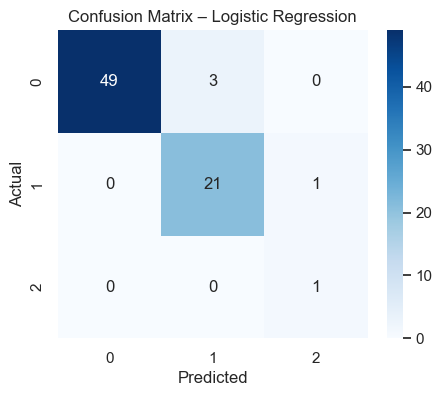


📊 Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.96      1.00      0.98        22
           2       1.00      1.00      1.00         1

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75

Accuracy: 0.987


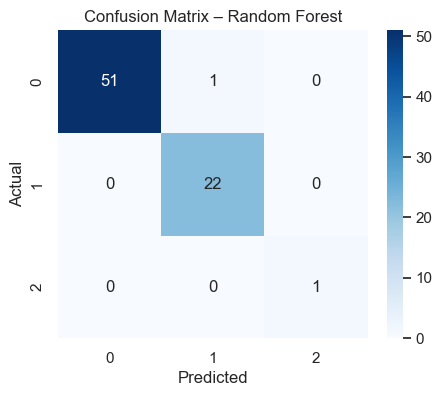

In [210]:
# ============================================================
# 📈 Evaluate Model Performance
# ============================================================

def evaluate_model(name, model, X_t, y_t):
    preds = model.predict(X_t)
    print(f"\n📊 {name} Results:")
    print(classification_report(y_t, preds))
    print("Accuracy:", round(accuracy_score(y_t, preds), 3))
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_t, preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.show()

evaluate_model("Logistic Regression", lr, X_test_scaled, y_test)
evaluate_model("Random Forest", rf, X_test, y_test)


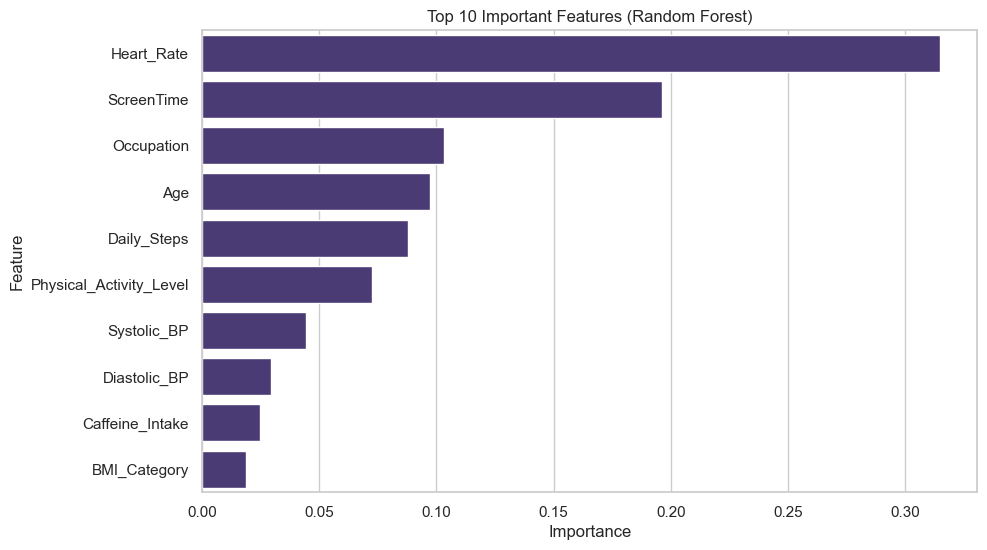

,Feature,Importance
5,Heart_Rate,0.315097
11,ScreenTime,0.196067
2,Occupation,0.103097
1,Age,0.097154
6,Daily_Steps,0.088011
3,Physical_Activity_Level,0.072314
8,Systolic_BP,0.044218
9,Diastolic_BP,0.029238
10,Caffeine_Intake,0.024742
4,BMI_Category,0.018624


In [211]:

# ============================================================
# 💡 Feature Importance (Random Forest)
# ============================================================

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title("Top 10 Important Features (Random Forest)")
plt.savefig("feature_importance_random_forest.png")
plt.show()

importance_df.head(10)


In [212]:
# ============================================================
# 💾 Save Models
# ============================================================

joblib.dump(lr, "sleep_lr_model.pkl")
joblib.dump(rf, "sleep_rf_model.pkl")
joblib.dump(scaler, "sleep_scaler.pkl")

print("\n✅ Models saved: sleep_lr_model.pkl, sleep_rf_model.pkl, sleep_scaler.pkl")



✅ Models saved: sleep_lr_model.pkl, sleep_rf_model.pkl, sleep_scaler.pkl


In [213]:
# ============================================================
# 🔮 Predict on New Data
# ============================================================

sample = pd.DataFrame({
    'Gender': [1],
    'Age': [25],
    'Occupation': [2],
    'Physical_Activity_Level': [40],
    'BMI_Category': [1],
    'Heart_Rate': [75],
    'Daily_Steps': [5000],
    'Sleep_Disorder': [1],
    'Systolic_BP': [125],
    'Diastolic_BP': [80],
    'Caffeine_Intake': [180],
    'ScreenTime': [5.5]
})

pred = rf.predict(sample)[0]
reverse_map = {0: 'Good', 1: 'Average', 2: 'Poor'}

print(f"\n🧠 Predicted Sleep Quality: {reverse_map[pred]}")



🧠 Predicted Sleep Quality: Good
